In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

Using TensorFlow backend.


In [6]:
import gensim
import numpy as np
import pandas as pd 

from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string, strip_short, strip_tags, remove_stopwords, strip_punctuation,strip_numeric, strip_multiple_whitespaces
from gensim import models

from pprint import pprint  # pretty-printer
from collections import defaultdict

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
%cd /content/drive/My\ Drive/nlp-2020


/content/drive/My Drive/nlp-2020


# Abstract

# Introduction

# Data analysis

## IMDB Reviews dataset and Preprocessing

In this project, we will make use of the <b>IMDB reviews dataset</b>. The data set was acquired from a [Kaggle competition](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). Overall, the dataset consists of 50000 movie reviews from IMDB and their corresponding sentiments. The sentiment can be whether positive or negative. Additionally, the sentiments ratio is 50-50 with half the reviews labelled as positive and the other half is negative. This is particularly useful for training since we will not have to deal with the imbalance in the dataset.

For training procedure, we will encode the sentiment values, assigning 1s to positives and 0s to negatives.

Let's take a quick glance at the dataset.

In [492]:
imdb = pd.read_csv('imdb.csv')

print(imdb.sentiment.value_counts())
# converting type of columns to 'category'
imdb['sentiment'] = imdb['sentiment'].astype('category')
# Assigning numerical values and storing in another column
imdb['sentiment'] = imdb['sentiment'].cat.codes


positive    25000
negative    25000
Name: sentiment, dtype: int64


Let's checkout the sample length distribution.

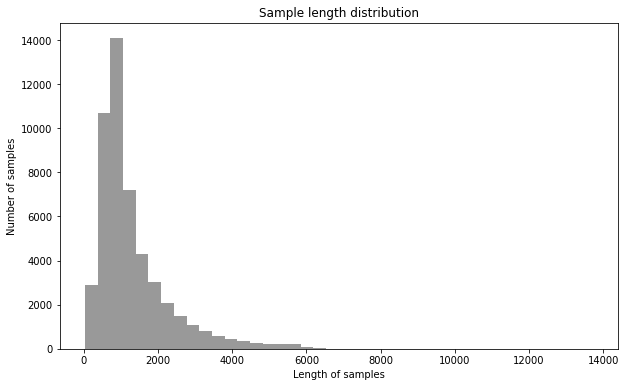

In [493]:
pal = sns.dark_palette("seagreen")
sns.set_palette(pal)

plt.figure(figsize=(10, 6))
sns.distplot([len(sample) for sample in list(imdb['review'])], kde=False, bins=40, color="black")
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

The reviews have an average length of 500 words. However, we also need to check out the number of unique words and their frequencies. 

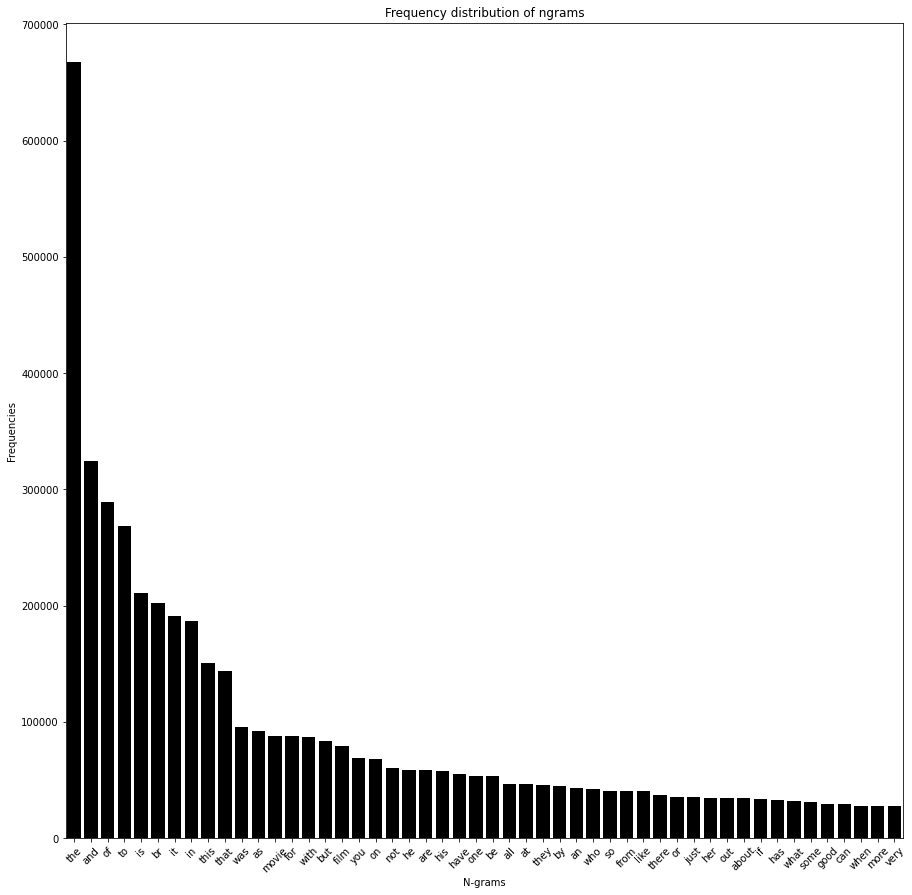

In [494]:
#Codes taken from https://www.kaggle.com/irinaabdullaeva/imdb-reviews-with-keras#Build-the-model
from sklearn.feature_extraction.text import CountVectorizer
def counts_word_freq(corpus):

    # Note that `ngram_range=(1, 1)` means we want to extract Unigrams, i.e. tokens.
    ngram_vectorizer = CountVectorizer(analyzer='word')
    # X matrix where the row represents sentences and column is our one-hot vector for each token in our vocabulary
    X = ngram_vectorizer.fit_transform(corpus)

    # Vocabulary

    all_ngrams = ngram_vectorizer.get_feature_names()
    num_ngrams = min(50, len(all_ngrams))
    all_counts = X.sum(axis=0).tolist()[0]

    all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
    ngrams = all_ngrams[:num_ngrams]
    counts = all_counts[:num_ngrams]

    idx = np.arange(num_ngrams)
    
    return idx, ngrams, counts
    

idx, ngrams, counts = counts_word_freq(list(imdb["review"]))

# Let's now plot a frequency distribution plot of the most seen words in the corpus.
plt.figure(figsize=(15, 15))
sns.barplot(idx, counts, color="black")
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

As seen from the plot above, the majority of words are stopwords. Those bring no value to our model since they do not represent the sentence's context. Using gensim preprocessing and Keras utilities, we will load the reviews corpus into a dictionary and tokenize them. The process consists of the following steps:

1. Simple preprocessing: excluding stopwords, punctuations, removing tags ("<i\>", "<br\>") etc.
2. Tokenization: assign each word with an id.
3. Sequence padding: this step is needed for the model training. As observed, the average length of reviews is 500, hence we will set a max length of 500 and pad the sequences with 0 or truncate the sequences whose lengths are greater than max value.

In [0]:
#Code acquired and modified from https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
# Returns the padded corpus, tokenizer and size of vocabulary
FILTERS = [lambda x: x.lower(), strip_short, strip_tags, strip_punctuation, remove_stopwords, strip_multiple_whitespaces]
def preprocessing(X, max_length=500):
    
    # Tokenize the corpus
    corpus = [preprocess_string(doc, FILTERS) for doc in X]

    # Create a toknenizer and fit on text
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    
    # Size of corpus' vocabulary
    vocab_size = len(tokenizer.word_index) + 1
    # integer encode the documents
    encoded_docs = tokenizer.texts_to_sequences(corpus)
    padded_corpus = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    
    return padded_corpus, vocab_size, tokenizer

padded_corpus, vocab_size, tokenizer = preprocessing(imdb["review"].values)

Demonstrating the result of the process. Notice that we have removed all the stopwords, punctuations and tags from the original reviews. The resulting sequence is much shorter than the original while the words order is also maintained.

In [496]:
# Example of padded sequence
sen = imdb["review"].values[3] 
print("Review: {}\n".format(sen))
print("Preprocessed review: {}\n".format(preprocess_string(sen, FILTERS)))
print("Sequence {}\n".format(padded_corpus[3][:25]))

Review: Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.

Preprocessed review: ['basically', 's', 'family', 'little', 'boy', 'jake', 'thinks', 's', 'zombie', 'closet', 'parents', 'fighting', 'time', 'movie', 'slower', 'soap', 'opera', 'suddenly', 'jake', 'decides', 'rambo', 'kill', 'zombie', 'ok', '

## GloVe embeddings

We will use the pre-trained GloVe embeddings for this project. The embeddings can be acquired from [here](https://nlp.stanford.edu/projects/glove/). Upon unarchiving, we can see that there are 4 different files. Each file contains the embeddings for 400000 words with different vector size. We will use the embeddings with 200 dimensions to train the model. Below is the embeddings for some words.

In [9]:
from numpy import asarray
from numpy import zeros

embeddings_index = dict()
f = open('glove.6B.200d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))


Loaded 400000 word vectors.


In [498]:
print("{}: {}".format("film",embeddings_index["the"][0:5])) 
print("{}: {}".format("wonderful",embeddings_index["the"][0:5])) 
print("{}: {}".format("terible",embeddings_index["the"][0:5])) 

film: [-0.071549  0.093459  0.023738 -0.090339  0.056123]
wonderful: [-0.071549  0.093459  0.023738 -0.090339  0.056123]
terible: [-0.071549  0.093459  0.023738 -0.090339  0.056123]


We will then assign the weights to our vocabulary. The results will be a weights matrix of size <b>(vocab_size,200)</b>, in which <b>vocab_size</b> being the number of distinct tokens from our processed sequences.

In [0]:
tokenizer.word_index.items()
vocab_size = len(tokenizer.word_index) +1
weights = np.zeros((vocab_size, 200), dtype=float)

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        weights[i] = embedding_vector

## Train/Test splitting

In [0]:
trains = padded_corpus
targets = imdb["sentiment"]

X_train,X_test, y_train, y_test = train_test_split(trains, targets, test_size=0.2)

In [501]:
print("Training samples:", len(X_train))
print("Test samples:", len(X_test))

Training samples: 40000
Test samples: 10000


# Models

Using pyTorch, we will perform a sentiment analysis on the IMDB dataset with a Recurrent Neural Network. There are 2 approaches to tackle this task. Firstly, we can use our processed corpus to train the Embedding layer of the network. Secondly, we can simply use the pre-trained GloVe embeddings to pass into the layer. Typically, training on top of a pre-trained embeddings often leads to a better result but we can evaluate both scenarios to see what works best for our problem.

## Original model

### Setup
This model takes as input the padded corpus and train its embedding layer. We will use a Sequential Keras model with the following layers:
1. Embedding layer: this layer will take in the padded corpus and assign weights to the token. The layer will output the dense vectors for all the words in our corpus.
2. Flatten layer: simply flatten the <b>(vocab size, embedding dimesion)</b> matrix to a 1D <b>(vocab size*embedding dimesion</b>). This step prepares an approriate input for the Dense layer.
3. Dense layer: Output a 1D vector which we will use to evaluate against the true labels.

Since we are tackling a binary classification problem, the <b>binary-cross entropy loss</b> is employed to compute the output loss. It simply computes the probability of an output and determine whethere this review is a positive one or not. The formula is as follows: 
                <center>$−(𝑦log(𝑝)+(1−𝑦)log(1−𝑝))$</center>

in which:

<i>p</i>: probability this review is positive
 
<i>y</i>: binary indicator (1 for positive, 0 for negative)

In [502]:
#Credit: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
EMBEDDING_DIM = 200
MAX_LENGTH = 500

# define model
orig_model = Sequential()
e = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LENGTH)
orig_model.add(e)
orig_model.add(Flatten())
orig_model.add(Dense(1, activation='sigmoid'))
# compile the model
orig_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(orig_model.summary())
# fit the model
history = orig_model.fit(X_train, y_train, epochs=50, verbose=0)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 200)          20906800  
_________________________________________________________________
flatten_10 (Flatten)         (None, 100000)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 100001    
Total params: 21,006,801
Trainable params: 21,006,801
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


TypeError: ignored

In [504]:

# serialize model to JSON
orig_model_json = orig_model.to_json()
with open("orig_model.json", "w") as json_file:
    json_file.write(orig_model_json)
# serialize weights to HDF5
orig_model.save_weights("orig_model.h5")
print("Saved model to disk")

Saved model to disk


### Evaluation
Evaluating the model on train data, we achieve an accuracy of 99.9%. The model does not perform particularly well on test data with an accuracy of around 80%. The ROC curve reveals the same information with the test curve being close to the middle baseline.

In [515]:
# evaluate the model
loss, accuracy = orig_model.evaluate(X_train, y_train, verbose=0)
print('Train accuracy: %f' % (accuracy*100))
loss, accuracy = orig_model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy: %f' % (accuracy*100))

Train accuracy: 99.997503
Test accuracy: 84.289998


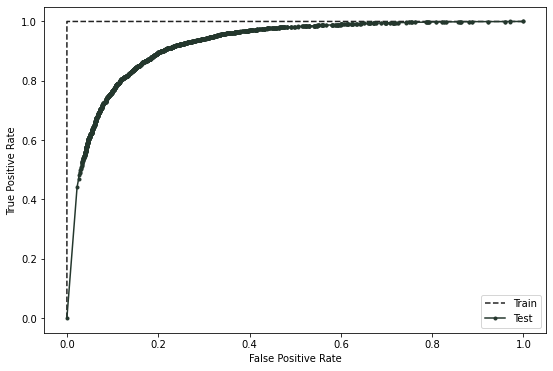

In [516]:
train_preds = orig_model.predict_proba(X_train)
test_preds = orig_model.predict_proba(X_test)

ns_fpr, ns_tpr, _ = roc_curve(y_train, train_preds)
lr_fpr, lr_tpr, _ = roc_curve(y_test, test_preds)
baseline = ns_probs = [0 for _ in range(len(y_test))]

plt.figure(figsize=(9, 6))
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Train')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Test')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### Nearest neighbours

We have acquired a set of embeddings after training the model. Let's perform some sanity checks to see if they are semantically meaningful. We will evaluate the words' similarity using cosine distance.

In [24]:
embeddings = e.get_weights()[0]
learned_embeddings = {w:embeddings[idx] for w, idx in tokenizer.word_index.items()}

NameError: ignored

In [0]:
from operator import itemgetter
def cosine_similarity(src, dst):
    cosine_similarity = np.dot(src, dst)/(np.linalg.norm(src)* np.linalg.norm(dst))
    return cosine_similarity

def most_similar(src, embeddings, top=3):
    similarities = []
    for word in embeddings:
        if word != src:
            cos_sim = cosine_similarity(embeddings[src], embeddings[word])
            similarities.append((word, cos_sim))
    return sorted(similarities,key=itemgetter(1), reverse=True)[:top]

def words_analogy(w1,w2,w3, embeddings, top=3):

    if w1 not in embeddings:
        print("Cant find {}".format(w1))
        return "<empty>"
    if w2 not in embeddings:
        print("Cant find {}".format(w2))
        return "<empty>"
    if w3 not in embeddings:
        print("Cant find {}".format(w3))
        return "<empty>"
    
    similarities = []
    v = embeddings[w1] - embeddings[w2] + embeddings[w3]
    for word in embeddings:
        if word != w1 and word != w2 and word != w3:
            cos_sim = cosine_similarity(v, embeddings[word])
            similarities.append((word, cos_sim))
    return sorted(similarities,key=itemgetter(1), reverse=True)[:top]  

def most_similar_words(vector, embeddings, top=3):
    similarities = []
    for word in embeddings:
        cos_sim = cosine_similarity(vector, embeddings[word])
        similarities.append((word, cos_sim))
    return sorted(similarities,key=itemgetter(1), reverse=True)[:top]
      

In [509]:
print("Word similarities:\n")
print("movie: {}".format(most_similar("movie", learned_embeddings)))
print("actor: {}".format(most_similar("actor", learned_embeddings)))
print("comedy: {}".format(most_similar("comedy", learned_embeddings)))

Word similarities:

movie: [('gods', 0.44475925), ('ladies', 0.39626837), ('newest', 0.39573383)]
actor: [('assailant', 0.48430166), ('radko', 0.47733304), ('agatha', 0.45624617)]
comedy: [('conveying', 0.43724343), ('binging', 0.37571022), ('tribeca', 0.3715757)]


We can see that the neighbour words are not particularly meaningful. This is mostly due to our limited vocabulary with only 100000 tokens. However, we can easily improve the embeddings by training our model on a much larger corpus.

## Pre-trained GloVe model

Using the above architecture, we will again train our model with the dataset. However, instead of making the models learn the embeddings, we will apply the pre-trained GloVe models in the Embedding layer

### Setup

In [510]:
#Credit: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
EMBEDDING_DIM = 200
MAX_LENGTH = 500

# define model
glove_model = Sequential()
e = Embedding(vocab_size, EMBEDDING_DIM, weights=[weights], input_length=MAX_LENGTH, trainable=False)
glove_model.add(e)
glove_model.add(Flatten())
glove_model.add(Dense(1, activation='sigmoid'))
# compile the model
glove_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())
# fit the model
history = glove_model.fit(X_train, y_train, epochs=50, verbose=0)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 500, 200)          20906800  
_________________________________________________________________
flatten_9 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 100001    
Total params: 21,006,801
Trainable params: 100,001
Non-trainable params: 20,906,800
_________________________________________________________________
None


In [512]:

# serialize model to JSON
glove_model_json = glove_model.to_json()
with open("glove_model.json", "w") as json_file:
    json_file.write(glove_model_json)
# serialize weights to HDF5
glove_model.save_weights("glove_model.h5")
print("Saved model to disk")

Saved model to disk


The number of trainable params is significantly lower because we do not have to train the embeddings from scratch.

### Evaluation

In [517]:
# evaluate the model
loss, accuracy = glove_model.evaluate(X_train, y_train, verbose=0)
print('Train accuracy: %f' % (accuracy*100))
loss, accuracy = glove_model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy: %f' % (accuracy*100))

Train accuracy: 99.742502
Test accuracy: 73.400003


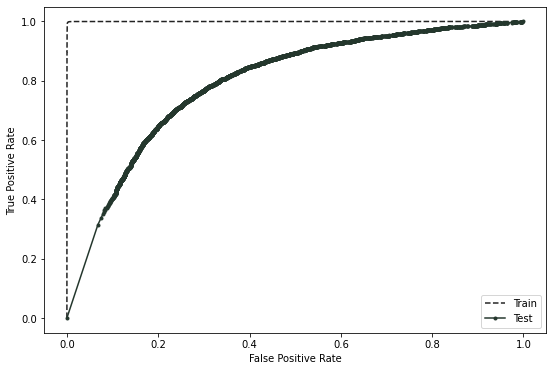

In [518]:
train_preds = glove_model.predict_proba(X_train)
test_preds = glove_model.predict_proba(X_test)

ns_fpr, ns_tpr, _ = roc_curve(y_train, train_preds)
lr_fpr, lr_tpr, _ = roc_curve(y_test, test_preds)
baseline = ns_probs = [0 for _ in range(len(y_test))]

plt.figure(figsize=(9, 6))
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Train')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Test')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### Analogical reasoning

In [519]:
print("Word similarities:\n")
print("movie: {}".format(most_similar("movie", embeddings_index)))
print("actor: {}".format(most_similar("actor", embeddings_index)))
print("comedy: {}".format(most_similar("comedy", embeddings_index)))

Word similarities:

movie: [('film', 0.88180614), ('movies', 0.8750335), ('films', 0.8414647)]
actor: [('actress', 0.75105745), ('starring', 0.7424192), ('actors', 0.7176447)]
comedy: [('comedies', 0.7667165), ('sitcom', 0.74692607), ('drama', 0.738278)]


This time, we can observe that the neighbour words have become more semantically meaningful. GloVe embedding is widely used by researchers so the result does not come as a surprise. We can further evaluate the embeddings on the course's analogical reasoning task. The process is described as follows:
1. Take in 4 words. The embeddings for the 3 first words are denoted as <b>(w1, w2, w3)</b>. 
2. Compute: <b>w = w2 - w1 + w3</b>
3. Find the closest vector to <b>w</b>. The word associated with the resulting vector should be analogically close to the group, in this case, <b>w4</b>.


In [520]:
tasks = pd.read_csv('analogical_reasoning_questions-words.txt', sep=" ", header=None)
tasks = tasks.apply(lambda x: x.astype(str).str.lower())
tasks.head()

,0,1,2,3
0,athens,greece,baghdad,iraq
1,athens,greece,bangkok,thailand
2,athens,greece,beijing,china
3,athens,greece,berlin,germany
4,athens,greece,bern,switzerland


In [521]:
import random 
def evaluate(tasks):
    for i in range(0,20):
        
        n = random.randint(1,3000)
        doc = tasks.values[n]
        w1 = doc[0]
        w2 = doc[1]
        w3 = doc[2]
        result = words_analogy(w2, w1, w3, embeddings_index)
        if isinstance(result, str):
            print("{} - {} + {} = {}".format(w2, w1, w3, result))
        else:
            print("{} - {} + {} = {}".format(w2, w1, w3, result[0][0]))

evaluate(tasks)    

jordan - amman + baghdad = iraq
switzerland - bern + libreville = gabon
afghanistan - kabul + kigali = rwanda
slovenia - ljubljana + lusaka = zambia
sudan - khartoum + paramaribo = suriname
samoa - apia + baghdad = iraq
eritrea - asmara + bamako = mali
england - london + bern = fribourg
turkmenistan - ashgabat + astana = kazakhstan
belgium - brussels + lima = peru
thailand - bangkok + islamabad = pakistan
uganda - kampala + maputo = mozambique
hungary - budapest + libreville = gabon
greece - athens + oslo = norway
gambia - banjul + harare = zimbabwe
romania - bucharest + copenhagen = denmark
serbia - belgrade + berlin = germany
nigeria - abuja + apia = samoa
iraq - baghdad + belgrade = yugoslavia
vietnam - hanoi + athens = greece


We randomized the index and checked 20 random groups. The results were all analogically correct.

# Document similarity

Another application of word embeddings is the ability to calculate similarity degree between documents. Some popular methods are described in this [article](https://medium.com/@adriensieg/text-similarities-da019229c894). In this project, we will experiment with the cosine distance based method. The idea is that, given the mean vector of the embeddings forming 2 documents, we can compute the cosine distance between them. A distance close to 1 means that the documents are similar in context and vice versa.


In [25]:

def document_similarity(d1, d2, embeddings):
    v1 = np.mean([embeddings[w] for w in preprocess_string(d1, FILTERS) ], axis=0)
    v2 = np.mean([embeddings[w] for w in preprocess_string(d2, FILTERS)], axis=0)
    result = cosine_similarity(v1,v2)
    return result

document_similarity("I love it", "Fucking hate it", embeddings_index)


0.4625234

# Conclusion

# Appendix

# References